# Niave Composite Solve

This script will attempt to solve the system of equations on the composite medium (dielectric plus dielectic inclusions) for the cross-in-plane geometry example.
The domain is $\Omega = \left[0,1\right]^2$ with periodic boundary conditions.
The quasi-momentum $\theta$ is fixed for each problem.
The singular inclusions are the quantum graph $\mathbb{G}$ which consists of vertices and edges

\begin{align*}
    v_1 = (0.5,1.0), \quad v_2 = (0.0,0.5), \quad v_3 &= (0.5,0.5), \quad v_4 = (1.0,0.5), \quad v_5 = (0.5,0.0), \\
    l_{23} = l_{34} = & l_{53} = l_{31} = 0.5, \\
    \theta_{23} = \theta_{34} = \theta_1, &\quad \theta_{53} = \theta_{31} = \theta_2.
\end{align*}

The graph divides $\Omega$ into four regions (although in reality it's only one region by the periodic BCs) which we label $\Omega_i$ for $i=1,2,3,4$; ordered counterclockwise as 1 (bottom left), 2 (top left), 3 (top right) and 4 (bottom right).

This will be done through a niave finite-difference approximation to the operator that acts on each part of the domain.
The equations to solve are:

\begin{align*}
    -\Delta_{\theta}u &= \omega^2 u, \qquad x\in\Omega_i, \\
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} &= \omega^2 u_{jk} + \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right), \qquad x\in I_{jk}, \\
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3.
\end{align*}

__NOTE:__ We haven't done the analysis for when $\alpha_j\neq0$ for the composite measure.
The domain is also subject to the periodic boundary conditions $u(0,y) = u(1,y)$ and $u(x,0) = u(x,1)$.

We must first discretise our domain into a (for ease, uniform) $N\times N$ grid.
Since we _need_ meshpoints on the graph itself, it will be convenient for us to take $N$ odd, so that the points can be generated via `linspace`.
Set $h = \frac{1}{N-1}$ as the mesh width, and for each $i,j\in\{0,...,N-1\}$ we define $u_{i,j} = u(ih, jh)$.
We must now discretise our operators, and then assemble the Finite Difference Matrix (FDM) for the problem above.
We need to take into account the fact that we want to force adherence to periodic boundary conditions, so we build a $(N-1)\times(N-1)$ FDM, shaving off the "slave" boundaries $u(1,y)$ and $u(x,1)$ - we will reconstruct these from the solution.
This means that we only need to solve for the gridpoint values $u_{i,j}$ for $i,j\in\{0,...,N-2\}$, however also means that we need to remember that the value "to the left" of $u_{0,j}$ is $u_{N-2,j}$ for example, and similarly for the other boundaries.
We'll also have to do some array manipulation to insert the "slave" gridpoint values back int our solution for plotting and visualisation too.

We will elect to store the points $u_{i,j}$ column-wise, so we acquire a vector

\begin{align*}
    U = \begin{pmatrix} u_{0,0} \\ u_{0,1} \\ \vdots \\ u_{0,N-2} \\ u_{1,0} \\ u_{1,1} \\ \vdots \end{pmatrix},
\end{align*}

and running `U.resize((N-1,N-1))` will then produce an $(N-1)\times(N-1)$ matrix whose $ij$-th entry is $u_{i,j}$.
The following "translation" between the column vector and grid representation of the solution holds with the above setup;

\begin{align*}
    u_{i,j} = U[j + (N-1)i],
\end{align*}

for any $i,j\in\{0,...,N-2\}$.

In [1]:
# imports
import numpy as np
from numpy.random import choice, uniform
from scipy.linalg import eig

import matplotlib.pyplot as plt
from matplotlib import rc, cm
rc('text', usetex=True)
from mpl_toolkits.mplot3d import Axes3D

# number of meshpoints
# this is defined up here to save an argument being passed to M2C every time we want to use it
N = 65
if N%2==0:
    print('N = %d is not even, using N=%d instead' % (N, N+1))
    N += 1
# mesh width
h = 1./(N-1)

# gridpoint placements
x = y = np.linspace(0.,1.,num=N)

# basic functions
def M2C(i,j):
    '''
    Provides the column index in U for the gridpoint u_{i,j}.
    INPUTS:
        i,j: int, gridpoint indices
    OUTPUTS:
        c: int, index such that U[c] = u_{i,j}
    '''
    
    return j + (N-1)*i

## Assembling the FDM

`X[N//2]` = `Y[N//2]` $=0.5$ exactly, and thus identify the meshpoints which lie on the graph (`x` and `y` also have this point equal to $0.5$ as well).
The meshpoints which fall into each region $\Omega_i$ are now easily collected:
- $\Omega_1$ (bottom left) `X[:N//2]` and `Y[:N//2]`. That is, $i=0,...,N//2-1$ and $j=0,...,N//2-1$.
- $\Omega_2$ (top left) `X[:N//2]` and `Y[N//2+1:]`. That is, $i=0,...,N//2-1$ and $j=1+N//2,...,N-2$.
- $\Omega_3$ (top right) `X[N//2+1:]` and `Y[N//2+1:]`. That is, $i=1+N//2,...,N-2$ and $j1+N//2,...,N-2$.
- $\Omega_4$ (bottom right) `X[N//2+1:]` and `Y[:N//2]`. That is, $1+N//2,...,N-2$ and $j=0,...,N//2-1$.

The graph edges are also easily collated now:
- $I_{31}$: `X[N//2]` and `Y[N//2+1:]`,
- $I_{53}$: `X[N//2]` and `Y[:N//2]`,
- $I_{23}$: `X[:N//2]` and `Y[N//2]`,
- $I_{34}$: `X[N//2+1:]` and `Y[N//2]`,

and of course, $v_3$ lies at `X[N//2],Y[N//2]`.

For a gridpoint $i,j$ in one of the regions $\Omega_i$, we now build the FDM rows that correspond to the equation at that gridpoint.
Upon discretising, we arrive at

\begin{align*}
    -\Delta_{\theta}u_{i,j} &\approx
    \left(\lvert\theta\rvert^2 + 4h^{-2}\right)u_{i,j}
    - h^{-1}(h^{-1}+\mathrm{i}\theta_1)u_{i+1,j} - h^{-1}(h^{-1}-\mathrm{i}\theta_1)u_{i-1,j}
    - h^{-1}(h^{-1}+\mathrm{i}\theta_2)u_{i,j+1} - h^{-1}(h^{-1}-\mathrm{i}\theta_2)u_{i,j-1}.
\end{align*}

This uses _centred differences_ within the regions $\Omega_i$.

In [2]:
def RegionalFDM(M, region, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j in the region Omega_region.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        region: int, 1-4 specifying which region to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the region Omega_region will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    # Compute some common constants first
    h = 1./(N-1)
    sqMagTheta = theta[0]*theta[0] + theta[1]*theta[1]
    
    # determine correct indices to loop over via lookup
    if region==1:
        jR = range(N//2)
        iR = range(N//2)
    elif region==2:
        jR = range(1+N//2,N-1)
        iR = range(N//2)
    elif region==3:
        jR = range(1+N//2,N-1)
        iR = range(1+N//2,N-1)
    elif region==4:
        jR = range(N//2)
        iR = range(1+N//2,N-1)
    else:
        raise ValueError('Unrecognised region, got %d' % (region))
        
    # now insert the entries of the FDM for the given region
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    for j in jR:
        for i in iR:
            # this is the row that we are going to set
            Mrow = M2C(i,j)
            # u_{i,j} prefactor is placed on the diagonal
            M[Mrow, Mrow] = sqMagTheta + 4/(h*h)
            # now place u_{i-1,j} and u_{i+1,j} prefactors
            # take index modulo N, since if you're on the periodic boundary you need to 
            # loop to the other side of the domain
            iLeft = (i-1) % (N-1)
            iRight = (i+1) % (N-1)
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = - ( 1./h - 1.j*theta[0] ) / h
            M[Mrow, rightIndex] = - ( 1./h + 1.j*theta[0] ) / h
            # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
            jUp = (j+1) % (N-1)
            jDown = (j-1) % (N-1)
            upIndex = M2C(i,jUp)
            downIndex = M2C(i,jDown)
            M[Mrow, upIndex] = - ( 1./h + 1.j*theta[1] ) / h
            M[Mrow, downIndex] = - ( 1./h - 1.j*theta[1] ) / h
            # this completes the construction of this row of the FDM, we now have that
            # FDM[Mrow,:] * U[Mrow] defines the expression for -\Laplacian_{\theta} at i,j.
            if log:
                print('---')
                print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
                print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
                print('set values to l/r/u/p/HERE : ', M[Mrow, leftIndex], M[Mrow, rightIndex], M[Mrow, upIndex], 
                 M[Mrow, downIndex], M[Mrow, Mrow])
    if log: 
        print('Finished region: %d' % (region))
    return

For horizontal edges ($I_{23}$ and $I_{34}$) we have that

\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_1 \right)^2 u_{i,j} - \dfrac{\partial}{\partial n_{jk}}\left(u^+_{i,j} - u^-_{i,j}\right)
    &\approx
    (\theta_1^2 + 2h^{-1} + 2h^{-2})u_{i,j} 
    - h^{-1}(h^{-1} + \mathrm{i}\theta_1)u_{i+1,j} - h^{-1}(h^{-1} - \mathrm{i}\theta_1)u_{i-1,j}
    - h^{-1}u_{i,j+1} - h^{-1}u_{i,j-1},
\end{align*}

since $\theta_{jk}=\theta_1$ on horizontal edges.
This uses _centred differences_ for the derivative along the edge ($\dfrac{\mathrm{d}}{\mathrm{d}y}$) and one-sided derivatives for the traces of $u$ from the adjacent regions.
We can now construct the rows of the FDM corresponding to the horizontal edges.

In [3]:
def HorEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 23 or 34, specifying which horizontal edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./(N-1)
    # setup loop ranges based on the edge we are working on
    if edge==23:
        iR = range(N//2)
    elif edge==34:
        iR = range(1+N//2,N-1)
    else:
        raise ValueError('Unknown horizontal edge, got %d' % (edge))
    j = N//2 # j is constant for horizontal edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    for i in iR:
        # get row index
        Mrow = M2C(i,j)
        # u_{i,j} prefactor is placed on the diagonal
        M[Mrow, Mrow] = theta[0]*theta[0] + 2./h + 2./(h*h)
        # now place u_{i-1,j} and u_{i+1,j} prefactors
        # take index modulo N, since if you're on the periodic boundary you need to 
        # loop to the other side of the domain
        iLeft = (i-1) % (N-1)
        iRight = (i+1) % (N-1)
        leftIndex = M2C(iLeft, j)
        rightIndex = M2C(iRight, j)
        M[Mrow, leftIndex] = - ( 1./h - 1.j*theta[0] ) / h
        M[Mrow, rightIndex] = - ( 1./h + 1.j*theta[0] ) / h
        # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
        jUp = (j+1) % (N-1)
        jDown = (j-1) % (N-1)
        upIndex = M2C(i, jUp)
        downIndex = M2C(i, jDown)
        M[Mrow, upIndex] = - 1./h
        M[Mrow, downIndex] = - 1./h
        # this completes the construction of this row of the FDM, we now have that
        # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
        if log:
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
            print('set values to l/r/u/p/HERE : ', M[Mrow, leftIndex], M[Mrow, rightIndex], M[Mrow, upIndex], 
                 M[Mrow, downIndex], M[Mrow, Mrow])
    if log:
        print('Finished edge: I_%d' % (edge))      
    return

For the vertical edges ($I_{53}$ and $I_{31}$) we have that

\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_2 \right)^2 u_{i,j} - \dfrac{\partial}{\partial n_{jk}}\left(u^+_{i,j} - u^-_{i,j}\right)
    &\approx
    (\theta_2^2 + 2h^{-1} + 2h^{-2})u_{i,j}
    - h^{-1}u_{i+1,j} - h^{-1}u_{i-1,j}
    - h^{-1}(h^{-1} + \mathrm{i}\theta_2)u_{i,j+1} - h^{-1}(h^{-1} - \mathrm{i}\theta_2)u_{i,j-1},
\end{align*}

In [4]:
def VerEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 31 or 53, specifying which vertical edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./(N-1)
    # setup loop ranges based on the edge we are working on
    if edge==53:
        jR = range(N//2)
    elif edge==31:
        jR = range(1+N//2,N-1)
    else:
        raise ValueError('Unknown vertical edge, got %d' % (edge))
    i = N//2 # i is constant for vertical edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    for j in jR:
        # get row index
        Mrow = M2C(i,j)
        # u_{i,j} prefactor is placed on the diagonal
        M[Mrow, Mrow] = theta[1]*theta[1] + 2./h + 2./(h*h)
        # now place u_{i-1,j} and u_{i+1,j} prefactors
        # take index modulo N, since if you're on the periodic boundary you need to 
        # loop to the other side of the domain
        iLeft = (i-1) % (N-1)
        iRight = (i+1) % (N-1)
        leftIndex = M2C(iLeft, j)
        rightIndex = M2C(iRight, j)
        M[Mrow, leftIndex] = - 1./h
        M[Mrow, rightIndex] = - 1./h
        # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
        jUp = (j+1) % (N-1)
        jDown = (j-1) % (N-1)
        upIndex = M2C(i, jUp)
        downIndex = M2C(i, jDown)
        M[Mrow, upIndex] = - ( 1./h + 1.j*theta[1] ) / h
        M[Mrow, downIndex] = - ( 1./h - 1.j*theta[1] ) / h
        # this completes the construction of this row of the FDM, we now have that
        # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
        if log:
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
            print('set values to l/r/u/p/HERE : ', M[Mrow, leftIndex], M[Mrow, rightIndex], M[Mrow, upIndex], 
                 M[Mrow, downIndex], M[Mrow, Mrow])
    if log:
        print('Finished edge: I_%d' % (edge))
    return

For the gridpoint at $v_3$, which by definition is at position $(i,j)=(N//2,N//2)$, our FDM is already assuming continuity of the function here.
Instead, we shall encode the condition

\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3,
\end{align*}

here.
Again, we can put this into a nicer form for the FDM matrix, but also need to deal with what's happening with $\alpha_3$.
Moving $\alpha_3\neq 0$ to the LHS will ensure that the equation $\mathrm{FDM} U = \omega^2 U$ is still the discrete form of the original system --- leaving $\alpha_3$ with $\omega^2 u(v_3)$ would not represent a discrete version of this system.
This does mean there is a question to be had about what happens when $\alpha_3=0$ and how to properly discretise the system in this case.
I guess one would have to resort to a generalised eigenvalue solve, writing

\begin{align*}
    \left( \mathrm{FDM} - \beta\left(\omega^2\right) \right) U = 0,
\end{align*}

where $\beta(\omega^2)$ is just scalar multiplication by $\omega^2$ for every element save `M2C(N//2,N//2)`, which it zeros instead.

At any rate, we have that

\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk}(v_3) 
    &\approx
    h^{-1}\left( 4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} \right).
\end{align*}

Note that this reduction is only true because of our symmetries; which cancel out the $\theta_{jk}u_{i,j}$ terms pairwise and give the normal derivatives a $\pm$ sign depending on the edge orientation.

In [5]:
def v3FDM(M, a3, N, tol=1e-8, log=True):
    '''
    Construct the FDM row that corresponds to the gridpoint at the vertex v_3.
    Different behaviour occurs for when alpha_3 = 0 and when it is non-zero.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written.
        a3: float, the value of the coupling constant alpha_3 at v_3.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        M: Row N//2+N*N//2 will be populated with FDM entries.
        Overwrites any values previously stored in entries that are to be edited.    
        
    If a3 = 0, then the row is assembled as discretised above.
    If a3 != 0, then the row is assembled with a 1/a3 prefactor in front of the discretisation above.
    '''
    
    h = 1./(N-1)
    # v_3 always lies at gridpoint (i,j) = (N//2, N//2)
    i = j = N//2
    Mrow = M2C(i,j)
    
    # determine indices that will be used for neighbouring points
    iLeft = (i-1) % (N-1)
    iRight = (i+1) % (N-1)
    jUp = (j+1) % (N-1)
    jDown = (j-1) % (N-1)
    leftIndex = M2C(iLeft, j)
    rightIndex = M2C(iRight, j)
    upIndex = M2C(i, jUp)
    downIndex = M2C(i, jDown)
    
    M[Mrow, Mrow] = 4./h
    M[Mrow, leftIndex] = - 1./h
    M[Mrow, rightIndex] = - 1./h
    M[Mrow, upIndex] = - 1./h
    M[Mrow, downIndex] = - 1./h
    
    if log:
        print('---')
        print('[v3] Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
        print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('set values to l/r/u/p/HERE : ', M[Mrow, leftIndex], M[Mrow, rightIndex], M[Mrow, upIndex], 
                 M[Mrow, downIndex], M[Mrow, Mrow]) 
    
    if np.abs(a3)<=tol:
        # alpha_3 is 0, notify user and construct LHS without alpha_3^-1 factor
        print('alpha_3 is zero: take care when solving discretised system.')
    else:
        print('alpha_3 non zero: assembling with prefactor 1/alpha_3 at v_3.')
        # rescale row by alpha_3
        M[Mrow,:] /= a3
    return

## Analysing the FDM

The matrix $M=$ `FDM` is our discretised form of the operator that defines our equations above.
The system

\begin{align*}
    M U = \omega^2 U,
\end{align*}

when $\alpha_3\neq 0$ is the discretised form of the above equation.
When $\alpha_3 = 0$, we have to use a trick to ensure that we are still solving this system and introduce the function $\beta(\omega^2)$ which is defined as

\begin{align*}
    \beta:\mathbb{C}\rightarrow\mathbb{C}^{(N-1)\times (N-1)},  \qquad
    \left( \beta(z) \right)_{jk} = (\delta_{j,k} - \delta_{N//2, N//2})z.
\end{align*}

Essentially, zero-out the entry corresponding to $u(v_3)$.
Also define $B = \beta(z)/z$ to be the constant matrix, which is just the identity matrix with 0 on the diagonal in the position corresponding to the vertex v_3.
Also, there is actually no reason for us to assume that the eigenvalues are entirely real (at least for the time being, since I don't know if the FDM is even Hermitian either), so using $z$ here makes more sense.
Then the system above is discretised into

\begin{align*}
    M U = \beta(z) U = z B U,
\end{align*}

which can be solved by a generalised eigenvalue solver.

In [6]:
def B(N):
    '''
    Constructs the matrix B defined above.
    INPUTS:
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        B: (N*N,N*N) complex, defined above.
    '''
    
    B = np.eye((N-1)*(N-1), dtype=complex)
    row = M2C(N//2, N//2)
    B[row, row] = 0. + 0.j
    return B

def Beta(z, N):
    '''
    Evaluates the matrix \beta defined above.
    Note that the argument is just z, so use the convention z = omega^2 here.
    INPUTS:
        z: complex, z=omega^2.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        beta: (N*N,N*N) complex, defined above and evaluated at z.
    '''
    
    return z * B(N)

# This function is mainly a reality check to ensure that InsertSlaveNodes does it's job correctly.
def CheckPeriodicBCs(N, U, tol=1e-8):
    '''
    Given a solution vector for the Finite Difference approximation, check whether or not the
    solution satisfies the periodic boundary conditions at x=0 <-> x=N and y=0 <-> y=N.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: (N*N,) complex, solution vector to FDM approximation. Can also be of shape (N,N).
    OUTPUTS:
        tf: (2,) bool, True/False values depending on whether the periodic BCs are satisfied
    '''
    
    tf = np.array([True, True], dtype=bool)
    if U.ndim==1:
        # have been passed a column vector, need to reshape
        u = U.reshape((N,N))
    else:
        # should only have been passed a (N,N) array, so just copy this and use the values
        u = np.copy(U)
    uTB = u[N-1,:] - u[0,:]
    uLR = u[:,0] - u[:,N-1]
    tbMax = np.max(np.abs(uTB))
    lrMax = np.max(np.abs(uLR))
    
    if lrMax > tol:
        tf[0] = False
    if tbMax > tol:
        tf[1] = False
    
    return tf

# Function extracts only the real eigenvalues we get from the FDM
def RealEvalIndices(wVals, tol=1e-8):
    '''
    Given the eigenvalues that our FDM approximation believes solve the discretised problem, extract only those
    which are entirely real (to a given tolerance).
    Return a boolian array tf such that wVals[tf] returns the array slice of only the real eigenvalues
    INPUTS:
        wVals: (n,) complex, eigenvalues from which to find entirely real values
        tol: (optional) float - default 1e-8, tolerance within which to accept imaginary part = 0
    OUTPUTS:
        tf: (n,) bool, wVals[tf] returns the array slice of only the real eigenvalues in wVals
    '''
    
    return np.abs(np.imag(wVals))<=tol

# Filters out NaN and inf valued eigenvalues, because machines silly
def Purge(vals):
    '''
    Given an array of complex values, remove any infs or NaN values in the array.
    INPUTS:
        vals: (n,) complex, array of values possibly containing infs or NaNs
    OUTPUTS:
        v: (m,) complex, array of values in v that are not inf or NaN
        tf: (n,) bool, vals[tf] = v
    '''
    
    tf = ((~ np.isnan(vals)) & (~ np.isinf(vals)))
    v = vals[tf]
    return v, tf

def Herm(A):
    '''
    Returns Hermitian matrix (conjugate transpose) of the matrix A.
    INPUTS:
        A: (n,n) complex, complex matrix to transpose and conjugate
    OUTPUTS:
        AH: (n,n) complex, conjugate transpose of A
    '''
    return A.conj().T

# Checks whether the FDM is Hermitian or not - from our analytic expressions, I think it should be!
def IsHermitian(A, rtol=1e-5, atol=1e-8):
    '''
    Checks whether the matrix A is Hermitian to within the specified tolerances, 
    by comparing it elementwise to it's conjugate transpose.
    INPUTS:
        A: (n,n) complex, complex matrix to check is Hermitian
        rtol: float, relative tolerance
        atol: float, absolute tolerance
    For more information on rtol and atol, see numpy.allclose
    OUTPUTS:
        tf: bool, if True then A is Hermitian, otherwise False is returned.
    '''
    return np.allclose(A, Herm(A), rtol=rtol, atol=atol)

def IsSymmetric(A, rtol=1e-5, atol=1e-8):
    '''
    Checks whether the matrix A is symmetric to within the specified tolerances, 
    by comparing it elementwise to it's transpose.
    INPUTS:
        A: (n,n) complex, complex matrix to check is symmetric
        rtol: float, relative tolerance
        atol: float, absolute tolerance
    For more information on rtol and atol, see numpy.allclose
    OUTPUTS:
        tf: bool, if True then A is symmetric, otherwise False is returned.
    '''
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

## Plotting and Solution Reconstruction Tools

The following functions enable us to take a solution to the FDM-approximation, re-insert the values on the "slave" boundary, and visualise the resulting (eigen)function.

In [7]:
def InsertSlaveNodes(N, U, mat=True):
    '''
    Given a (N-1)^2 solution vector U, insert the values at the periodic "slave" meshpoints to form a N*N matrix, 
    or (N*N) column vector
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: ((N-1)**2,) complex, column vector of eigenfunction values at (non-slave) meshpoints
        mat: bool - default True, if True, return an (N,N) matrix and otherwise return a (N*N,) column vector
    OUTPUTS:
        u: (N,N) or (N*N,) complex, representation of the solution U with "slave" gridpoint values appended
    '''

    # setup solution
    u = np.zeros((N,N), dtype=complex)
    # setup view of U to make life easier
    Uview = U.reshape((N-1,N-1))
    # copy values across, don't edit column vector U
    u[:N-1,:N-1] = Uview
    # insert missing "right boundary"
    u[N-1,:N-1] = np.copy(Uview[0,:])
    # insert missing "top boundary"
    u[:N-1,N-1] = np.copy(Uview[:,0])
    # insert point at (N-1,N-1) which has not yet been set
    u[N-1,N-1] = np.copy(u[0,0])
    if (not mat):
        u.resize((N*N,))
    
    return u

def PlotFn(N, U, levels=10):
    '''
    Create contour plots for the eigenfunction U that is passed in.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: ((N-1)**2,) complex, column vector of eigenfunction values at (non-slave) meshpoints
        levels: (optional) int - default 10, number of contour levels to pass to contourf.
    OUTPUTS:
        Two lists of the form [fig, ax] for the handles of the matplotlib figures,
        the first containing the plot of the real part of U and 
        the second containing the plot of the imaginary part of U.
    '''
    
    # gridpoints used
    x = y = np.linspace(0,1, num=N)
    # restore "slave" meshpoints
    u = InsertSlaveNodes(N, U, mat=True)
    # plot handles
    rFig, rAx = plt.subplots()
    iFig, iAx = plt.subplots()
    # axis setup
    for a in [rAx, iAx]:
        a.set_aspect('equal')
        a.set_xlabel(r'$x_1$')
        a.set_ylabel(r'$x_2$')
    rAx.set_title(r'$\Re (u)$')
    iAx.set_title(r'$\Im (u)$')
    
    # if more levels than meshpoints in each dimension, could be difficult! Throw a warning
    if levels >= N:
        print('Number of contour levels exceeds or equals N!')
    # make contour plots
    rCon = rAx.contourf(x, y, np.real(u), levels=levels)
    iCon = iAx.contourf(x, y, np.imag(u), levels=levels)
    # make colourbars
    rFig.colorbar(rCon)
    iFig.colorbar(iCon)
    
    return [rFig, rAx], [iFig, iAx]

def PlotFn3D(N, U):
    '''
    Create 3D-surface plots for the eigenfunction U that is passed in.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: ((N-1)**2,) complex, column vector of eigenfunction values at (non-slave) meshpoints
    OUTPUTS:
        Two lists of the form [fig, ax] for the handles of the matplotlib figures,
        the first containing the plot of the real part of U and 
        the second containing the plot of the imaginary part of U.    
    '''

    # gridpoints used
    x = y = np.linspace(0,1, num=N)
    X, Y = np.meshgrid(x,y)
    # restore "slave" meshpoints
    u = InsertSlaveNodes(N, U, mat=True)
    # plot handles
    rFig = plt.figure(); rAx = rFig.add_subplot(111, projection='3d')
    iFig = plt.figure(); iAx = iFig.add_subplot(111, projection='3d')
    # axis setup
    for a in [rAx, iAx]:
        a.set_xlabel(r'$x_1$')
        a.set_ylabel(r'$x_2$')
        a.set_zlabel(r'$u(x)$')
        a.set_xlim([0.,1.])
        a.set_ylim([0.,1.])
    rAx.set_title(r'$\Re (u)$')
    iAx.set_title(r'$\Im (u)$')
    
    # make contour plots
    rCon = rAx.plot_surface(X, Y, np.real(u), cmap=cm.viridis, linewidth=0)
    iCon = iAx.plot_surface(X, Y, np.imag(u), cmap=cm.viridis, linewidth=0)
    # make colourbars
    rFig.colorbar(rCon)
    iFig.colorbar(iCon)
    
    return [rFig, rAx], [iFig, iAx]

# visual check on what Python thinks the eigenvalues of the FDM actually are
def PlotEvals(wVals, N=0, autoPlotWidow=False):
    '''
    Creates a (scatter) plot on the 2D complex plane of the distribution of "eigenvalues" found by the FDM method.
    INPUTS:
        wVals: (n,) complex, eigenvalues found from the FDM solve
        N: (optional) int, the number of meshpoints in each dimension, will be inferred if not provided explicitly
    OUTPUTS:
        fig, ax: matplotlib figure handles, contains a 2D scatter plot of the eigenvalues in the complex plane
    If N is not provided, the function assumes that wVals contains all the eigenvalues for it's mesh, IE that 
    len(wVals) = n = (N-1)^2.
    '''
    
    # can recover mesh size from number of eigenvalues found if we need to
    if N==0:
        N = np.sqrt(len(wVals)) + 1
    # otherwise, N is set for us by the user for cases when only a selection of the e'vals are to be plotted
    
    fig, ax = plt.subplots()
    #ax.set_aspect('equal')
    ax.set_title(r'Eigenvalues in the complex plane (N=%d)' % (N))
    ax.set_xlabel(r'$\Re(z)$')
    ax.set_ylabel(r'$\Im(z)$')
    ax.scatter(np.real(wVals), np.imag(wVals), marker='x', s=2, c='black')
    
    return fig, ax

def SmallestValuesIndex(a, k=19):
    '''
    Return the indices of the k smallest values in the array a. By default, k is the minimum of 19 and len(a).
    INPUTS:
        a: (n,) float, values to search
        k: (optional) int, the indices corresponding to the k-smallest values in a will be returned
    OUTPUTS:
        inds: (k,) int, the indices corresponding to the k-smallest values in a
    Note that inds will not be sorted in ascending order, in general a[inds[i-1]] !< a[inds[i]].
    '''
    if k>len(a):
        return np.argpartition(a, len(a))
    return np.argpartition(a, k)[:k]

## Execution of Assembly and Analysis begins here

From here, we use the functions we defined above to assemble the FDM and then analyse what comes out of it.

In [8]:
# Begin assembly script here.

# quasi-momentum value
#theta = np.array([0.,0.], dtype=float)
#theta = np.array([np.pi/3,0.], dtype=float)
#theta = np.array([np.pi/3,np.pi/3], dtype=float)
theta = uniform(-np.pi, np.pi, size=(2,))
print('Quasi-momentum set as: ', theta/np.pi, '\pi')

# coupling constant at v_3
alpha3 = 0.0

logOn = False
sizeFDM = (N-1)*(N-1)
# Initalise FDM
FDM = np.zeros((sizeFDM,sizeFDM), dtype=complex)

# Assemble row entries for each region
for r in range(4):
    RegionalFDM(FDM, r+1, N, theta, log=logOn)

# Assemble row entries for each horizontal edge
for he in [23,34]:
    HorEdgeFDM(FDM, he, N, theta, log=logOn)

# Assemble row entries for each vertical edge
for ve in [31,53]:
    VerEdgeFDM(FDM, ve, N, theta, log=logOn)
    
# Assemble row entry for v_3
v3FDM(FDM, alpha3, N, log=logOn)

Quasi-momentum set as:  [-0.44087816  0.05454077] \pi
alpha_3 is zero: take care when solving discretised system.


FDM Sparsity pattern:


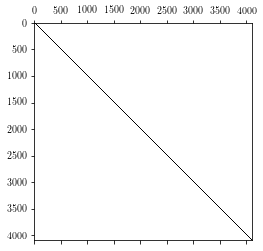

FDM is NOT Symmetric nor Hermitian, see FDM - FDM.H below:


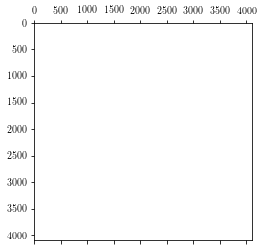

Max real difference:  4032.0
Max imag difference:  88.64381330688589


In [9]:
# Check sparsity pattern of FDM
print('FDM Sparsity pattern:')
plt.spy(FDM)
plt.show()

# Is it Hermitian?
if IsHermitian(FDM):
    print('FDM is Hermitian')
elif IsSymmetric(FDM):
    print('FDM is symmetric')
else:
    print('FDM is NOT Symmetric nor Hermitian, see FDM - FDM.H below:')
    diff = FDM - Herm(FDM)
    plt.spy(diff)
    plt.show()
    print('Max real difference: ', np.max(np.abs(np.real(diff))))
    print('Max imag difference: ', np.max(np.abs(np.imag(diff))))

In [10]:
# Compute e'values and e'vectors.
# NOTE: if alpha_3 is zero, will need to insert B(N) for a generalised eigenvalue problem
# Otherwise, we can just pass FDM into eig
print('Eigenvalue solving, this may take a while...', end='')
wVals, wVecs = eig(FDM, B(N))
print(' finished')

Eigenvalue solving, this may take a while... finished


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


----- Analysis ----- 
 #E-vals found: 4096
#Inf/NaN values: 1
#Real eigenvalues: 4095
Reconstructed solutions: Periodic 4096 / LR fail 0 / TB fail 0 / Both fail 0


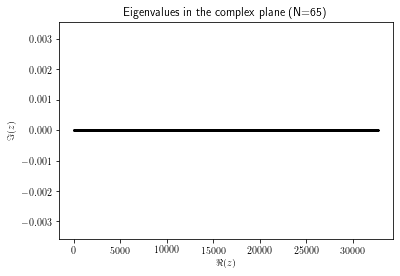

In [11]:
# reconstruct every solution and check that the result is periodic (slave boundaries have been matched correctly)
p = 0; lrFail = 0; tbFail = 0
for w in range(len(wVals)):
    wV = InsertSlaveNodes(N, wVecs[:,w], mat=True)
    tf = CheckPeriodicBCs(N, wV)
    if (tf[0] and tf[1]):
        # this solution is fine upon reconstruction
        p += 1
    elif tf[0]:
        # lr boundary fine, tb boundary not periodic
        tbFail += 1
        print('E-vec at index %d not periodic Top <-> Bottom' % (w))
    elif tf[1]:
        # tb boundary fine, lr boundary not periodic
        lrFail += 1
        print('E-vec at index %d not periodic Left <-> Right' % (w))
    else:
        # no periodicity on either solution!
        lrFail += 1
        tbFail += 1
        print('E-vec at index %d not periodic in either direction' % (w))

# visualise the eigenvalues that we found
eFig, eAx = PlotEvals(wVals)
eFig.show()
# now try this but for only the real eigenvalues?
# clear infs and NaN evals
eVals, tf = Purge(wVals)
eVecs = wVecs[:,tf]
realTF = RealEvalIndices(eVals, tol=1e-8)
#eRFig, eRAx = PlotEvals(eVals[realTF], N) #need to pass N here as otherwise the inference will be wrong!
#eRFig.show()

print('----- Analysis ----- \n #E-vals found: %d' % (len(wVals)))
print('#Inf/NaN values: %d' % (len(wVals)-len(eVals)))
print('#Real eigenvalues: %d' % (np.sum(realTF)))
print('Reconstructed solutions: Periodic %d / LR fail %d / TB fail %d / Both fail %d' %
      (p,lrFail,tbFail,lrFail+tbFail+p-len(wVals)))

Plotting with 15 contour levels
Finding 19 smallest eigenvalues... finished.


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through th

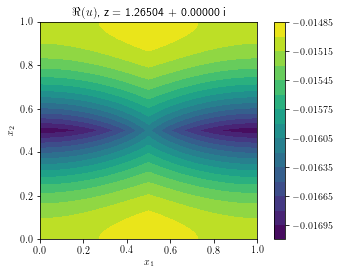

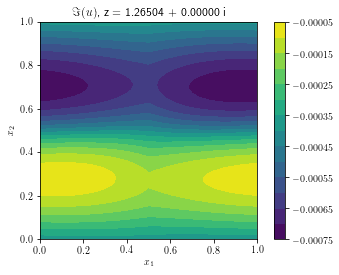

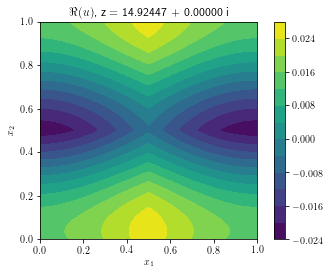

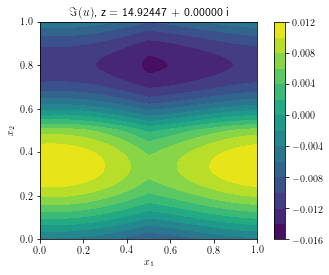

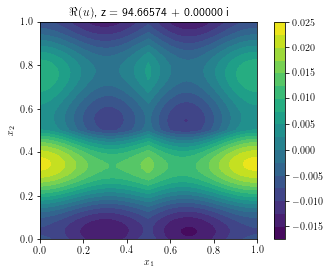

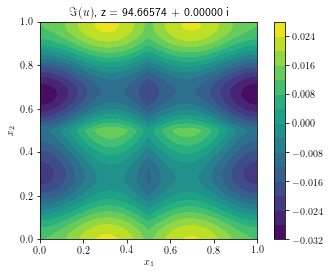

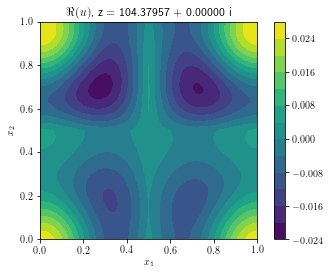

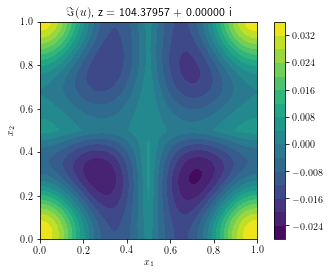

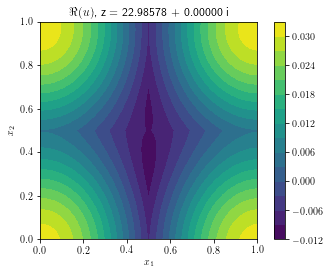

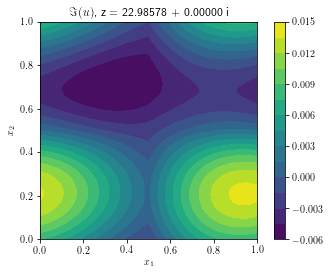

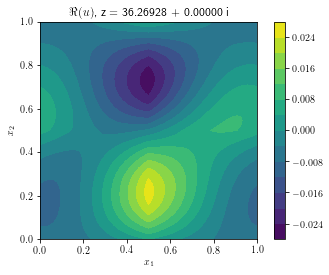

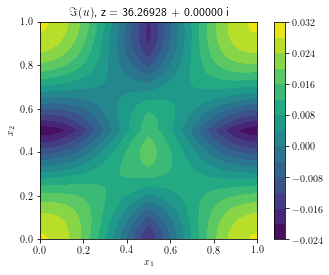

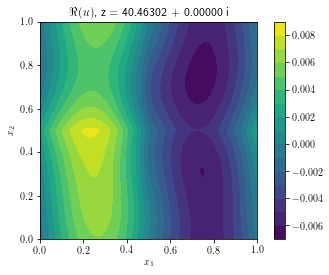

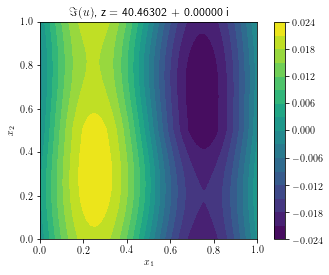

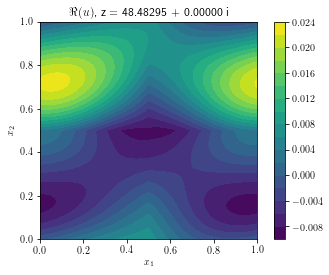

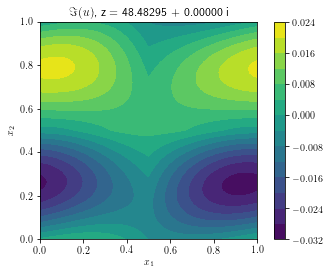

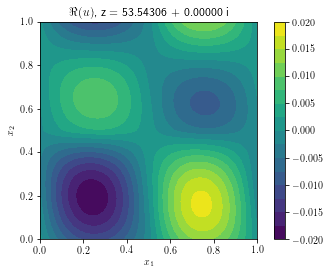

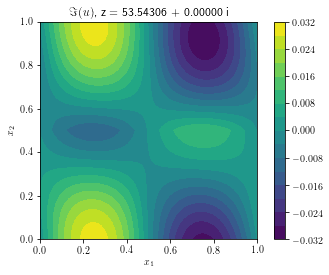

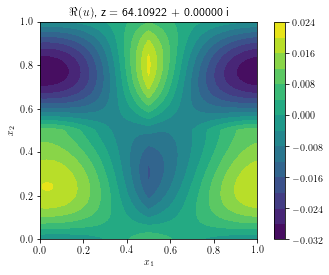

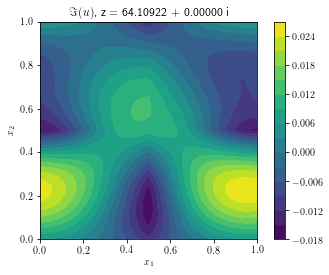

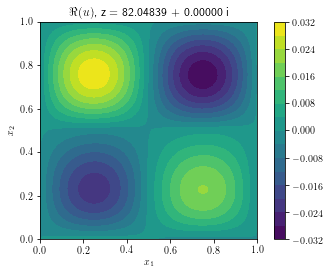

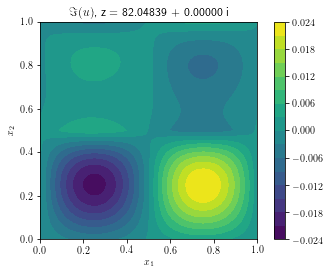

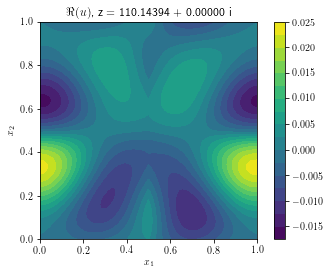

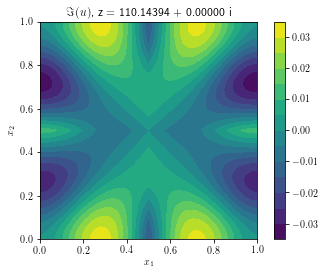

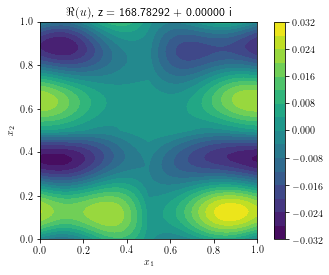

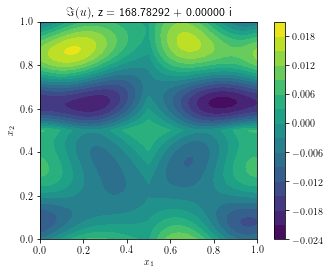

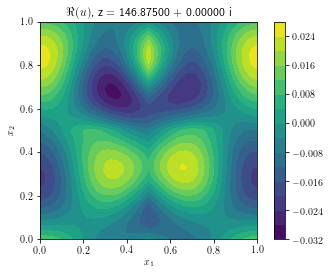

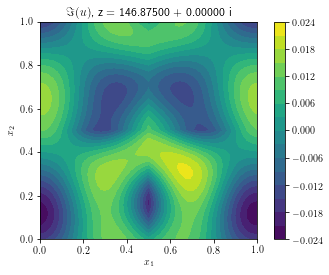

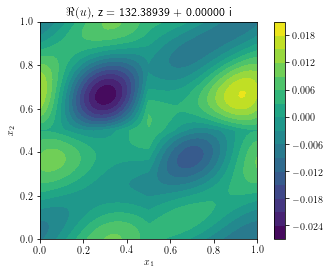

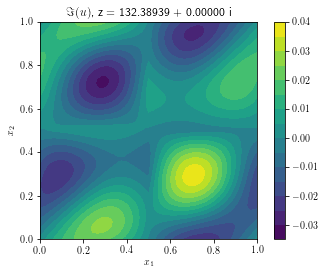

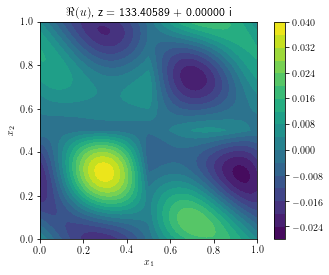

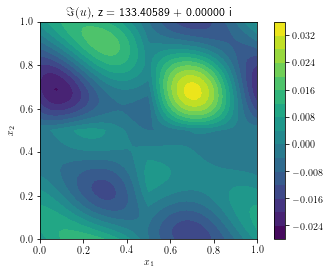

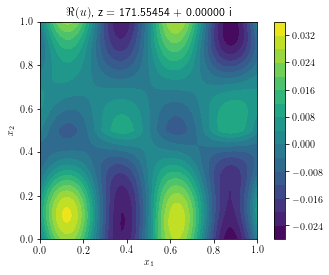

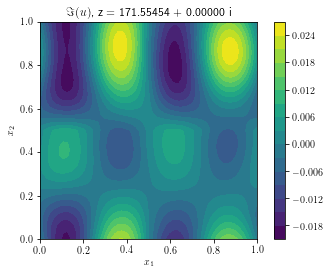

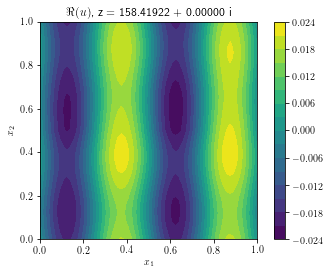

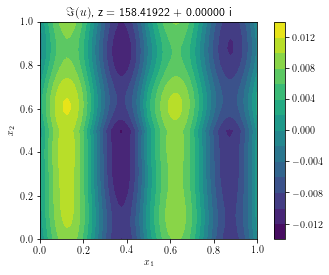

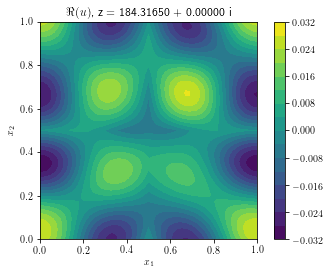

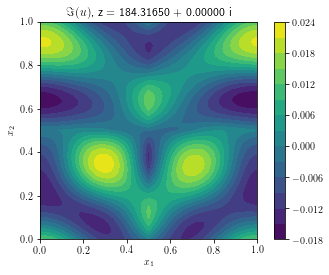

In [12]:
# close all figures that are currently open
plt.close('all')

# what do you want to plot?
plotSmallestReal = True
plotRandomGood = False
plotRandom = False

# plot some solutions based off the eigenvalue distribution?
goodVals = np.real(eVals[realTF]) #safe to only take real part of these eigenvalues
goodVecs = eVecs[:,realTF]

levels = np.min([N//2, 15])
print('Plotting with %d contour levels' % (levels))

# catch small arrays of "good" eigenvalues
if len(goodVals)>20:
    k = 19
else:
    k = len(goodVals)
#retrieve indices of smallest eigenvalues
print('Finding %d smallest eigenvalues...' % (k), end='')
smallestEvalInds = SmallestValuesIndex(goodVals, k)
print(' finished.')

# plot the e'vals closest to 0. Only plot 19 due to memory limitations
if plotSmallestReal:
    for i in smallestEvalInds:
        z = goodVals[i]
        rW, iW = PlotFn(N, goodVecs[:,i], levels=levels)
        rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        rW[0].show()
        iW[0].show()

# plot a random selection of "good" eigenfunctions
if plotRandomGood:
    eSelection = goodVals
    if len(eSelection)<20:
        # >20 figures causes MemoryError due to pyplot interface limitations
        for i, z in enumerate(eSelection):
            rW, iW = PlotFn(N, goodVecs[:,i], levels=levels)
            rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
            iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
            rW[0].show()
            iW[0].show()
    else:
        # if we have more than 20 good values, randomly select 19 of them
        subSet = choice(np.arange(len(eSelection)), (19,))
        print('>20 eVals, chose to plot:', subSet)
        for i in subSet:
            z = goodVals[i]
            rW, iW = PlotFn(N, goodVecs[:,i], levels=levels)
            rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
            iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
            rW[0].show()
            iW[0].show()

/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


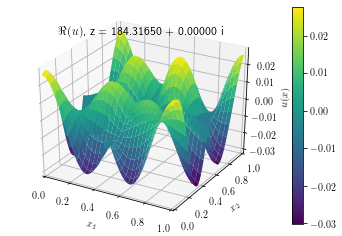

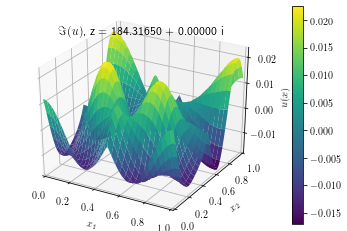

In [13]:
plt.close('all')

i = smallestEvalInds[-1]
z = goodVals[i]
rW3d, iW3d = PlotFn3D(N,goodVecs[:,i])
rW3d[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
iW3d[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
rW3d[0].show()
iW3d[0].show()

In [14]:
plt.close('all')

# plot a selection again, but this time don't restrict to only the real eigenvalues
if plotRandom:
    subSet = choice(np.arange(len(eVals)), (19,))
    print('>20 eVals, chose to plot:', subSet)
    for i in subSet:
        z = eVals[i]
        rW, iW = PlotFn(N, eVecs[:,i], levels=levels)
        rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        rW[0].show()
        iW[0].show()

In [15]:
plt.close('all')